In [62]:
#Packages
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [63]:
#Dataset
root_dir = 'D:/PROJECTS/face_keyp/data/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('D:/PROJECTS/face_keyp/data/training_frames_keypoints.csv')
data[0:5]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [64]:
data.shape

(3462, 137)

In [65]:
#Define the FacesData class that provides input and output data points for the data loader

class FacesData(Dataset):
    def __init__(self, df):
        '''Initializes the data frame and defines the mean and std for preprocessing'''
        super(FacesData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(
                              mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, ix):
        '''fetch image and scale
           fetch key point and normalize 
           from a given index ix'''
        img_path = 'D:/PROJECTS/face_keyp/data/training/' + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255 #Scale
        #Normalize the expected output values (key points) as a proportion of
        #the size of the original image
        kp = deepcopy(self.df.iloc[ix,1:].tolist()) 
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    
    def preprocess_input(self, img):
        '''function to pre-process an image'''
        img = cv2.resize(img, (224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)

    def load_img(self, ix):
        '''Load image to help visualize'''
        img_path = 'D:/PROJECTS/face_keyp/data/training/' + self.df.iloc[ix,0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img


In [66]:
#Creating training and test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=101)
#split the training and test datasets by person name in the input data frame
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [68]:
#Define the model

def get_model():
    #Load pre-trained VGG16 model
    model = models.vgg16(pretrained=True)
    #Ensure the parameters are frozen
    for param in model.parameters():
        param.requires_grad = False
    #Overwrite and unfreeze the parameters of the last two layers of the model   
    model.avgpool = nn.Sequential(nn.Conv2d(512,512,3),
                                  nn.MaxPool2d(2),nn.Flatten())
    model.classifier = nn.Sequential(nn.Linear(2048, 512),nn.ReLU(),
                                     nn.Dropout(0.5),nn.Linear(512, 136), 
                                     nn.Sigmoid())
    #Define the loss function
    criterion = nn.L1Loss() #MAE loss
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    return model.to(device), criterion, optimizer

In [69]:
model, criterion, optimizer = get_model()

In [70]:
#Define functions to train on a batch of data points and also to validate on
#the test dataset
def train_batch(img, kps, model, optimizer, criterion):
    '''function to train on a batch of data points'''
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

def validate_batch(img, kps, model, criterion):
    ''''function to validate on the test dataset'''
    model.eval()
    with torch.no_grad():
        _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss
  

In [71]:
#Train the model based on training the data loader and test it on test data
train_loss, test_loss = [], []
n_epochs = 20

for epoch in range(n_epochs):
    print(f" epoch {epoch + 1} : 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1 : 50
 epoch 2 : 50
 epoch 3 : 50
 epoch 4 : 50
 epoch 5 : 50
 epoch 6 : 50
 epoch 7 : 50
 epoch 8 : 50
 epoch 9 : 50
 epoch 10 : 50
 epoch 11 : 50
 epoch 12 : 50
 epoch 13 : 50
 epoch 14 : 50
 epoch 15 : 50
 epoch 16 : 50
 epoch 17 : 50
 epoch 18 : 50
 epoch 19 : 50
 epoch 20 : 50


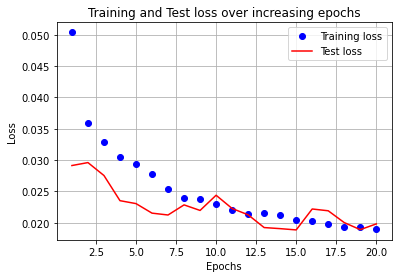

In [74]:
#Plot the training and test loss over increasing epochs:
epochs = np.arange(20)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

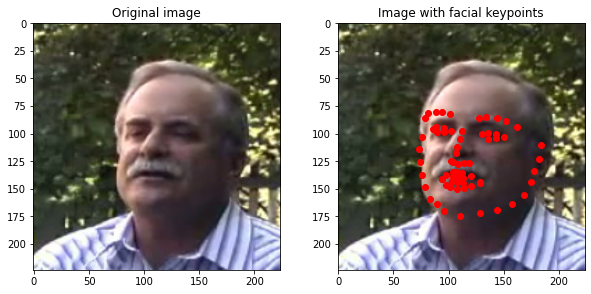

In [80]:
#Test our model on a random test image's index
ix = 3
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

In [82]:
#torch.save(model.state_dict(), 'D:/PROJECTS/face_keyp/model/vgg_keypd.pth')

In [83]:
#the_model = TheModelClass(*args, **kwargs)
#the_model.load_state_dict(torch.load(PATH))